In [8]:
import copy
import json
import os
import numpy as np
import kernel
import configuration
import calibration
from matplotlib import pyplot as plt

In [2]:
def test_data(c_path, w_path, e_path, json_path, offset=1, printing=True): 
    descriptors = np.loadtxt(c_path)
    weights = np.loadtxt(w_path)
    e_ave = np.loadtxt(e_path)[0]
    with open(json_path, 'r') as u_conf:
            user_config = json.load(u_conf)

    # make a list of the allowed qs
    qs = np.arange(1, user_config['nr_modi']+1) * np.pi / user_config['cutoff']

    # read in data and save parameters for calibration comparison
    (nc_new, ni_new, lat, configurations) = calibration.load_data(user_config, offset)

    config = configurations[0]
    
    if printing:
        for key, value in user_config.items():
            if type(value) != list:
                print(f'{key:>15}: {value:<15}')
            else:
                print(f'{key:>15}: {value[0]:<15}')
                print(f'{"sigma":>15}: {value[1]:<15}')

    nc_old = int(weights.size / 64)
    ni_old = 64

    kern = kernel.Kernel(*user_config['kernel'])

    config.init_nn(user_config['cutoff'], lat)
    config.init_descriptor(qs)

    E, F_reg = kern.predict(qs, config, descriptors, weights, e_ave)
    
    delta_F = F_reg - config.forces
    F_mean = np.mean(np.linalg.norm(delta_F, axis=1))
    F_var = np.var(np.linalg.norm(delta_F, axis=1))

    signs_reg = np.sign(F_reg)
    signs_ana = np.sign(config.forces)
    sign_diff = signs_reg - signs_ana
    
    if printing:
        print('\nPredicted values:')
        print(f'energy = {E}')
        print(f'forces = {F_reg[1]}\n')

        print('Values from Outcar:')
        print(f'energy = {config.energy}')
        print(f'forces = {config.forces[1]}')
        print('\nSign differences:', sign_diff[sign_diff != 0].size, 'out of', sign_diff.size)
        #print(sign_diff)


        print(f'Mean norm of difference:\n {F_mean} +- {F_var}')
        print(f'Relative to size of F:\n {F_mean / np.mean(np.linalg.norm(config.forces, axis=1))}')
    return(F_mean, F_var,  sign_diff[sign_diff != 0].size)



In [27]:
def test_sigmas(n: int, modi: int):
    sigmas = [i * .25 for i in range(1, n+1)]
    mean_fit = []
    var_fit = []
    signs_fit = []
    mean_pred = []
    var_pred = []
    signs_pred = []
    for sigma in sigmas:
        us_cfg = {
            "file_in": "OUTCAR.21",
            "file_out": "data",
            "stepsize": 100,
            "cutoff": 4,
            "nr_modi": modi,
            "lambda": 1e-12,
            "kernel": ["gaussian", sigma]
        }
        with open('user_config.json', 'w') as json_out:
            json.dump(us_cfg, json_out)
        os.system('python calibration.py')
        fitting = test_data('data/calibration_C.out', 
                            'data/calibration_w.out', 
                            'data/calibration_E.out', 
                            'user_config.json', 
                            0,
                            False)
        prediction = test_data('data/calibration_C.out', 
                               'data/calibration_w.out', 
                               'data/calibration_E.out', 
                               'user_config.json', 
                               1,
                               False)
        mean_fit.append(fitting[0])
        var_fit.append(fitting[1])
        signs_fit.append(fitting[2])

        mean_pred.append(prediction[0])
        var_pred.append(prediction[1])
        signs_pred.append(prediction[2])
        print(sigma)
        np.savetxt(f'test_data/fit_{us_cfg["nr_modi"]}.dat', np.array([sigmas, mean_fit, var_fit, signs_fit]).T)
        np.savetxt(f'test_data/predict_{us_cfg["nr_modi"]}.dat', np.array([sigmas, mean_pred, var_pred, signs_pred]).T)

# Linear Kernel

In [3]:
test_data('test_data/c_lin_10.out', 'test_data/w_lin_10.out', 'test_data/e_lin_10.out', 'test_data/lin_10.json')


        file_in: OUTCAR.21      
       file_out: test_data      
       stepsize: 1000           
         cutoff: 4              
        nr_modi: 10             
         lambda: 0.001          
         kernel: linear         
          sigma:                

Predicted values:
energy = -307.3937472587071
forces = [ 0.6930024  -0.21777951 -0.47929145]

Values from Outcar:
energy = -306.56723878
forces = [ 0.463753 -0.593154 -0.339427]

Sign differences: 28 out of 192
Mean norm of difference:
 0.49890646576586417 +- 0.04779279743831686
Relative to size of F:
 0.3724728151966518


(0.49890646576586417, 0.04779279743831686, 28)

# Gaussian Kernel

In [4]:
test_data('test_data/c_gaus_10.out', 'test_data/w_gaus_10.out', 'test_data/e_gaus_10.out', 'test_data/gaus_10.json')     

        file_in: OUTCAR.21      
       file_out: test_data      
       stepsize: 1000           
         cutoff: 4              
        nr_modi: 10             
         lambda: 0.001          
         kernel: gaussian       
          sigma: 1              

Predicted values:
energy = -307.9103162022497
forces = [-32.09861649  -5.30471067 -13.71075235]

Values from Outcar:
energy = -306.56723878
forces = [ 0.463753 -0.593154 -0.339427]

Sign differences: 92 out of 192
Mean norm of difference:
 28.491481832043167 +- 1205.438889367551
Relative to size of F:
 21.271126303834496


(28.491481832043167, 1205.438889367551, 92)

# Bigger sigma

In [5]:
test_data('data/calibration_C.out', 'data/calibration_w.out', 'data/calibration_E.out', 'user_config.json', 0)

        file_in: OUTCAR.21      
       file_out: data           
       stepsize: 100            
         cutoff: 4              
        nr_modi: 10             
         lambda: 1e-12          
         kernel: gaussian       
          sigma: 43.5           

Predicted values:
energy = -322.755429689861
forces = [ 0.05307643  0.46457891 -0.6442697 ]

Values from Outcar:
energy = -306.41169589
forces = [ 0.354149 -0.521376 -0.257292]

Sign differences: 56 out of 192
Mean norm of difference:
 1.2767101672902608 +- 0.39015734229006993
Relative to size of F:
 0.9287398543484863


(1.2767101672902608, 0.39015734229006993, 56)

0.25
fitting (1.2784417745786427, 0.5714806658012885, 69)
prediction (279494.45285323274, 145696051586.3811, 100)
0.5
fitting (0.9009676439655472, 0.2871935085257352, 42)
prediction (1002770.7752068447, 917016784832.8169, 97)
0.75
fitting (0.8568412694689886, 0.19056606157264339, 41)
prediction (5854.799214258304, 83760195.17699547, 88)
1.0
fitting (0.8229404086309244, 0.14754001917564685, 40)
prediction (36.242356766910035, 2104.1072290120296, 92)
1.25
fitting (0.7924000215495142, 0.13280246439375726, 35)
prediction (4.212186346571375, 9.4319612389682, 82)
1.5
fitting (0.7722946777933839, 0.15673110125319278, 37)
prediction (1.9420877480507353, 1.8088883971535523, 74)
1.75
fitting (0.7253415784716728, 0.15520709026505242, 38)
prediction (1.3836750351792566, 0.951504241200297, 63)
2.0
fitting (0.6652227092894698, 0.10614234690003886, 37)
prediction (1.0951340366020192, 0.49341177499104283, 53)
2.25
fitting (0.6225319265830218, 0.06285066044640035, 32)
prediction (0.9098530524710644, 0.

18.0
fitting (0.5801098719533094, 0.07614602518041493, 39)
prediction (0.5750638132278922, 0.07445993789643734, 35)
18.25
fitting (0.464937202295052, 0.031912399597383845, 22)
prediction (0.4798444867390963, 0.040114009271359344, 23)
18.5
fitting (0.5876039551267067, 0.0548366612697516, 29)
prediction (0.5711315379243966, 0.07299055912372536, 36)
18.75
fitting (0.6693832667979431, 0.09477746814132049, 37)
prediction (0.6951247976015078, 0.10658023311185372, 47)
19.0
fitting (0.4521558546123286, 0.03141586796767702, 19)
prediction (0.45688252847137756, 0.03760401160186248, 25)
19.25
fitting (0.4623787610308282, 0.026997938090689778, 20)
prediction (0.4783272553508743, 0.03163217803866556, 23)
19.5
fitting (0.5325865295348042, 0.04524755521454033, 30)
prediction (0.5555779149091475, 0.04400581715246732, 35)
19.75
fitting (0.42152634365748565, 0.03233803224532286, 19)
prediction (0.43774811210580594, 0.032826085372121644, 23)
20.0
fitting (0.6360643976514901, 0.1046743072496005, 34)
predi

35.75
fitting (1.186076780149626, 0.4042616811397475, 55)
prediction (1.1545588695049145, 0.26197095920001956, 49)
36.0
fitting (0.6071188420292675, 0.0680485949946486, 31)
prediction (0.6093363325936132, 0.05704617065878907, 35)
36.25
fitting (0.4512417829884321, 0.03285270353653053, 23)
prediction (0.45374235734161594, 0.03438299963544067, 26)
36.5
fitting (1.007005455685536, 0.28291255310353636, 45)
prediction (1.001911471005579, 0.24101087153395298, 43)
36.75
fitting (0.7298276881458848, 0.13806735103863788, 36)
prediction (0.7254505137044006, 0.1261148864660985, 32)
37.0
fitting (1.7282521889761715, 0.6767331524862785, 63)
prediction (1.7431882300958668, 0.7593821247029446, 58)
37.25
fitting (0.8970953930460119, 0.16352460579038658, 40)
prediction (0.9105555833876532, 0.18511981731111274, 45)
37.5
fitting (0.467068113502174, 0.03742459490951879, 26)
prediction (0.4587537177019351, 0.033925284150803245, 25)
37.75
fitting (0.5165600151591916, 0.04530162524510805, 26)
prediction (0.5

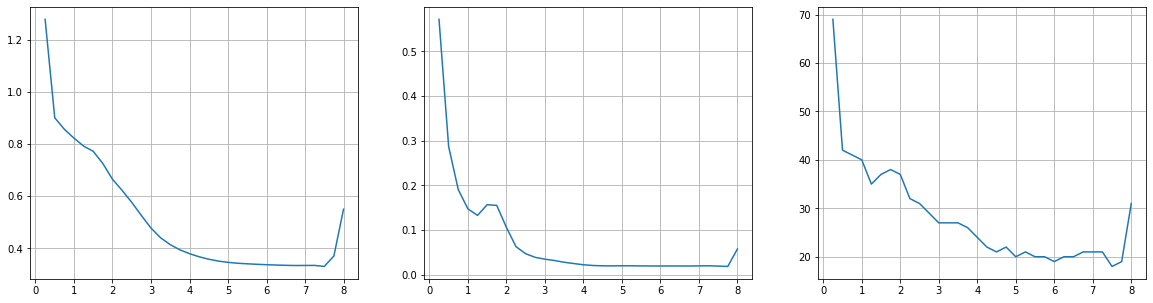

In [41]:
max_n = 32
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
axs[0].plot(sigmas[:max_n], mean_fit[:max_n])
axs[0].grid()
axs[1].plot(sigmas[:max_n], var_fit[:max_n])
axs[1].grid()
axs[2].plot(sigmas[:max_n], signs_fit[:max_n])
axs[2].grid()

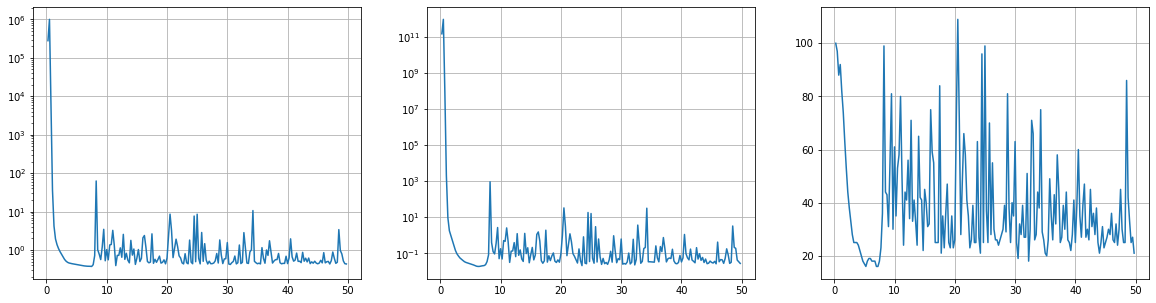

In [48]:
max_n = -1
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
axs[0].plot(sigmas[:max_n], mean_pred[:max_n])
axs[0].grid()
axs[0].set_yscale('log')
axs[1].plot(sigmas[:max_n], var_pred[:max_n])
axs[1].grid()
axs[1].set_yscale('log')

axs[2].plot(sigmas[:max_n], signs_pred[:max_n])
axs[2].grid()
